# Parallel Processing with Dask

Dask is a **distributed task** processing library.

> Dask is a flexible parallel computing library for analytics. Dask brings scalability to xarray objects; its data structures are capable of representing extremely large datasets without actually loading them in memory, and its distributed schedulers permit supercomputers and cloud computing clusters to efficiently parallelize computations across many nodes.

Open Data Cube can use dask to load more data than will fit on memory, and to use computing power across multiple computers or server nodes. 

## Resources
For further reading on how dask works, and how it is used by xarray, see these resources:

 * http://xarray.pydata.org/en/stable/dask.html
 * https://dask.readthedocs.io/en/latest/
 * http://stephanhoyer.com/2015/06/11/xray-dask-out-of-core-labeled-arrays/

In [1]:
import datacube

dc = datacube.Datacube()

By default, calls to `dc.load()` will return an array with all of the requested data loaded into memory.

In [2]:
data = dc.load(
    product='ga_ls8c_ard_3', measurements=['nbart_red', 'nbart_green', 'nbart_blue'],
    lat=(-35, -36), lon=(148, 149), time='2018-01-01', group_by='solar_day',
    resolution=(30,30), output_crs='epsg:3577'
)
data

<xarray.Dataset>
Dimensions:      (time: 1, x: 3473, y: 4062)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01T23:56:37.516439
  * y            (y) float64 -4.035e+06 -4.035e+06 ... -3.913e+06 -3.913e+06
  * x            (x) float64 1.439e+06 1.439e+06 ... 1.543e+06 1.543e+06
Data variables:
    nbart_red    (time, y, x) int16 2505 2451 2340 2304 2280 ... 882 841 850 832
    nbart_green  (time, y, x) int16 2541 2501 2383 2342 2330 ... 753 675 676 682
    nbart_blue   (time, y, x) int16 2452 2422 2353 2308 2270 ... 472 430 424 424
Attributes:
    crs:      epsg:3577

To avoid this, data can be "lazy-loaded". This means instead of loading the data immediately, it is only retrevied when it is actually going to be used. This is done by using `dask.DataArray` arrays instead of `numpy.ndarray` arrays inside the `xarray.DataArray` or `.Dataset` objects returned by Open Data Cube.

To request lazy-loaded data, add a `dask_chunks` parameter to your `dc.load()` call:

In [3]:
lazy_data = dc.load(
    product='ga_ls8c_ard_3', measurements=['nbart_red', 'nbart_green', 'nbart_blue'],
    lat=(-35, -36), lon=(148, 149), time='2018-01-01', group_by='solar_day',
    resolution=(30,30), output_crs='epsg:3577',
    dask_chunks={'time': 1, 'x': 3000, 'y': 3000}
)
lazy_data

<xarray.Dataset>
Dimensions:      (time: 1, x: 3473, y: 4062)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01T23:56:37.516439
  * y            (y) float64 -4.035e+06 -4.035e+06 ... -3.913e+06 -3.913e+06
  * x            (x) float64 1.439e+06 1.439e+06 ... 1.543e+06 1.543e+06
Data variables:
    nbart_red    (time, y, x) int16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    nbart_green  (time, y, x) int16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    nbart_blue   (time, y, x) int16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
Attributes:
    crs:      epsg:3577

The function should return much faster, as it is not reading any data from disk.

In the data variables section above, we can see it is using dask arrays with the chunksize we specified.

The key to using dask arrays is that the large array is broken up into chunks, which can be read individually.  You must specify the size of each chunk in pixels for each dimension of the array.

In [4]:
dask_chunks = {'time': 1, 'x': 3000, 'y': 3000}

This sets the x and y dimensions to be 2000 pixels each. We set time to 1 as the sandbox data is stored in geotiff files that only have 1 time each, so there is no benefit of reading more the one at once.

If a value is not present, or if it set to -1, then the chunk will stretch the entire length of the array in that dimension.

The `.data` attribute on an `xarray.DataArray` gives us the underlying `dask.Array`, which shows a grapic when in a jupyter notebook.  We can see that it has split the array into 4 chunks:

In [5]:
lazy_data.nbart_red.data

dask.array<dc_load_nbart_red, shape=(1, 4062, 3473), dtype=int16, chunksize=(1, 3000, 3000), chunktype=numpy.ndarray>

## Loading lazy data

To load the data from disk, call `.load()` on the `DataArray` or `Dataset`.

In [6]:
loaded_data = lazy_data.load()

In [7]:
loaded_data

<xarray.Dataset>
Dimensions:      (time: 1, x: 3473, y: 4062)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01T23:56:37.516439
  * y            (y) float64 -4.035e+06 -4.035e+06 ... -3.913e+06 -3.913e+06
  * x            (x) float64 1.439e+06 1.439e+06 ... 1.543e+06 1.543e+06
Data variables:
    nbart_red    (time, y, x) int16 2505 2451 2340 2304 2280 ... 882 841 850 832
    nbart_green  (time, y, x) int16 2541 2501 2383 2342 2330 ... 753 675 676 682
    nbart_blue   (time, y, x) int16 2452 2422 2353 2308 2270 ... 472 430 424 424
Attributes:
    crs:      epsg:3577

The internal arrays (`dask.array<chunksize=(1, 2000, 2000), meta=np.ndarray>`) have now been replace with actual numbers.  This is the same as the data array from our first query.

## Lazy operations

The above example just delayed the loading, the result is still the same size, and hasn't made use of any additional computers.

In [8]:
lazy_data = dc.load(
    product='ga_ls8c_ard_3', measurements=['nbart_red', 'nbart_nir'],
    lat=(-35, -36), lon=(148, 149), time='2018-01-01', group_by='solar_day',
    resolution=(30,30), output_crs='epsg:3577',
    dask_chunks={'time': 1, 'x':3000, 'y': 3000}
)
lazy_data

<xarray.Dataset>
Dimensions:    (time: 1, x: 3473, y: 4062)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01T23:56:37.516439
  * y          (y) float64 -4.035e+06 -4.035e+06 ... -3.913e+06 -3.913e+06
  * x          (x) float64 1.439e+06 1.439e+06 1.439e+06 ... 1.543e+06 1.543e+06
Data variables:
    nbart_red  (time, y, x) int16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    nbart_nir  (time, y, x) int16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
Attributes:
    crs:      epsg:3577

Dask has broken the loading into a series of steps.  We can see these steps in the task graph:

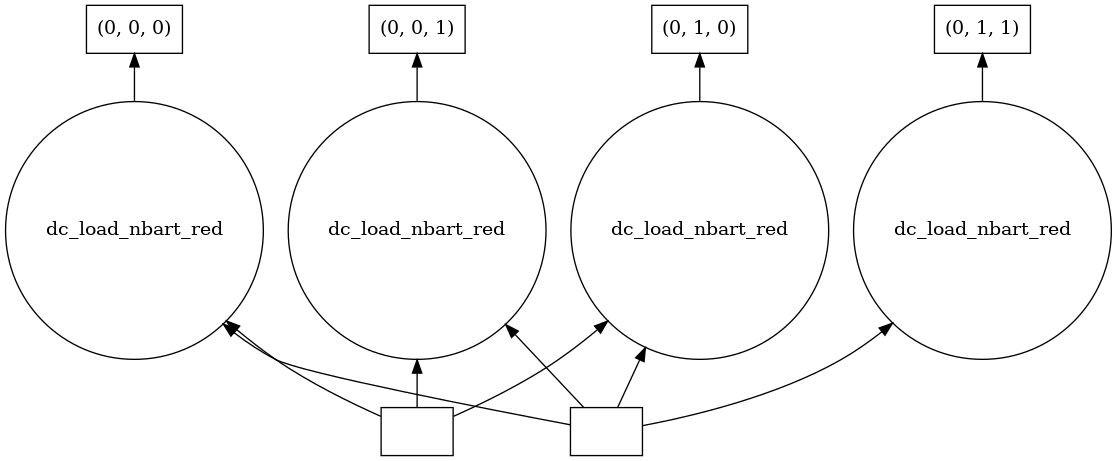

In [9]:
lazy_data.nbart_red.data.visualize()

The task graph is read from bottom to top.

The 2 bottom rectangles are the datasets entires containing the metadata of the files that will be read. Above these are individual load commands that will do the reading.  At the very top are the indexes of the chunks that will make the final array.

We can add a step to the graph that will only read a small portion of the array.  When we call `.load()` on this extracted array, it will only perform the steps in the graph required for the output.

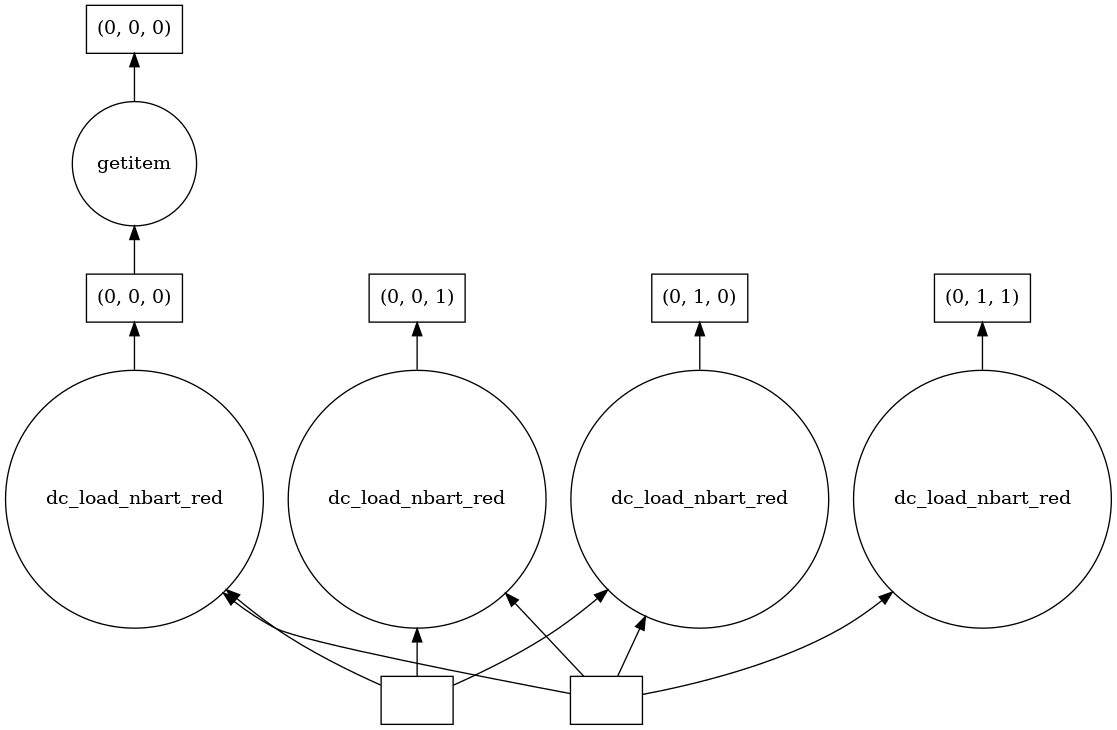

In [10]:
extract_from_red = lazy_data.nbart_red[:, 100:200, 100:200]
extract_from_red.data.visualize()

### Band Math Example

We can do other operations on our arrays, such as raster band math, such as calculating the Normalized Difference Vegetation Index:

In [11]:
red = lazy_data.nbart_red
nir = lazy_data.nbart_nir

ndvi = (nir - red) / (nir + red)

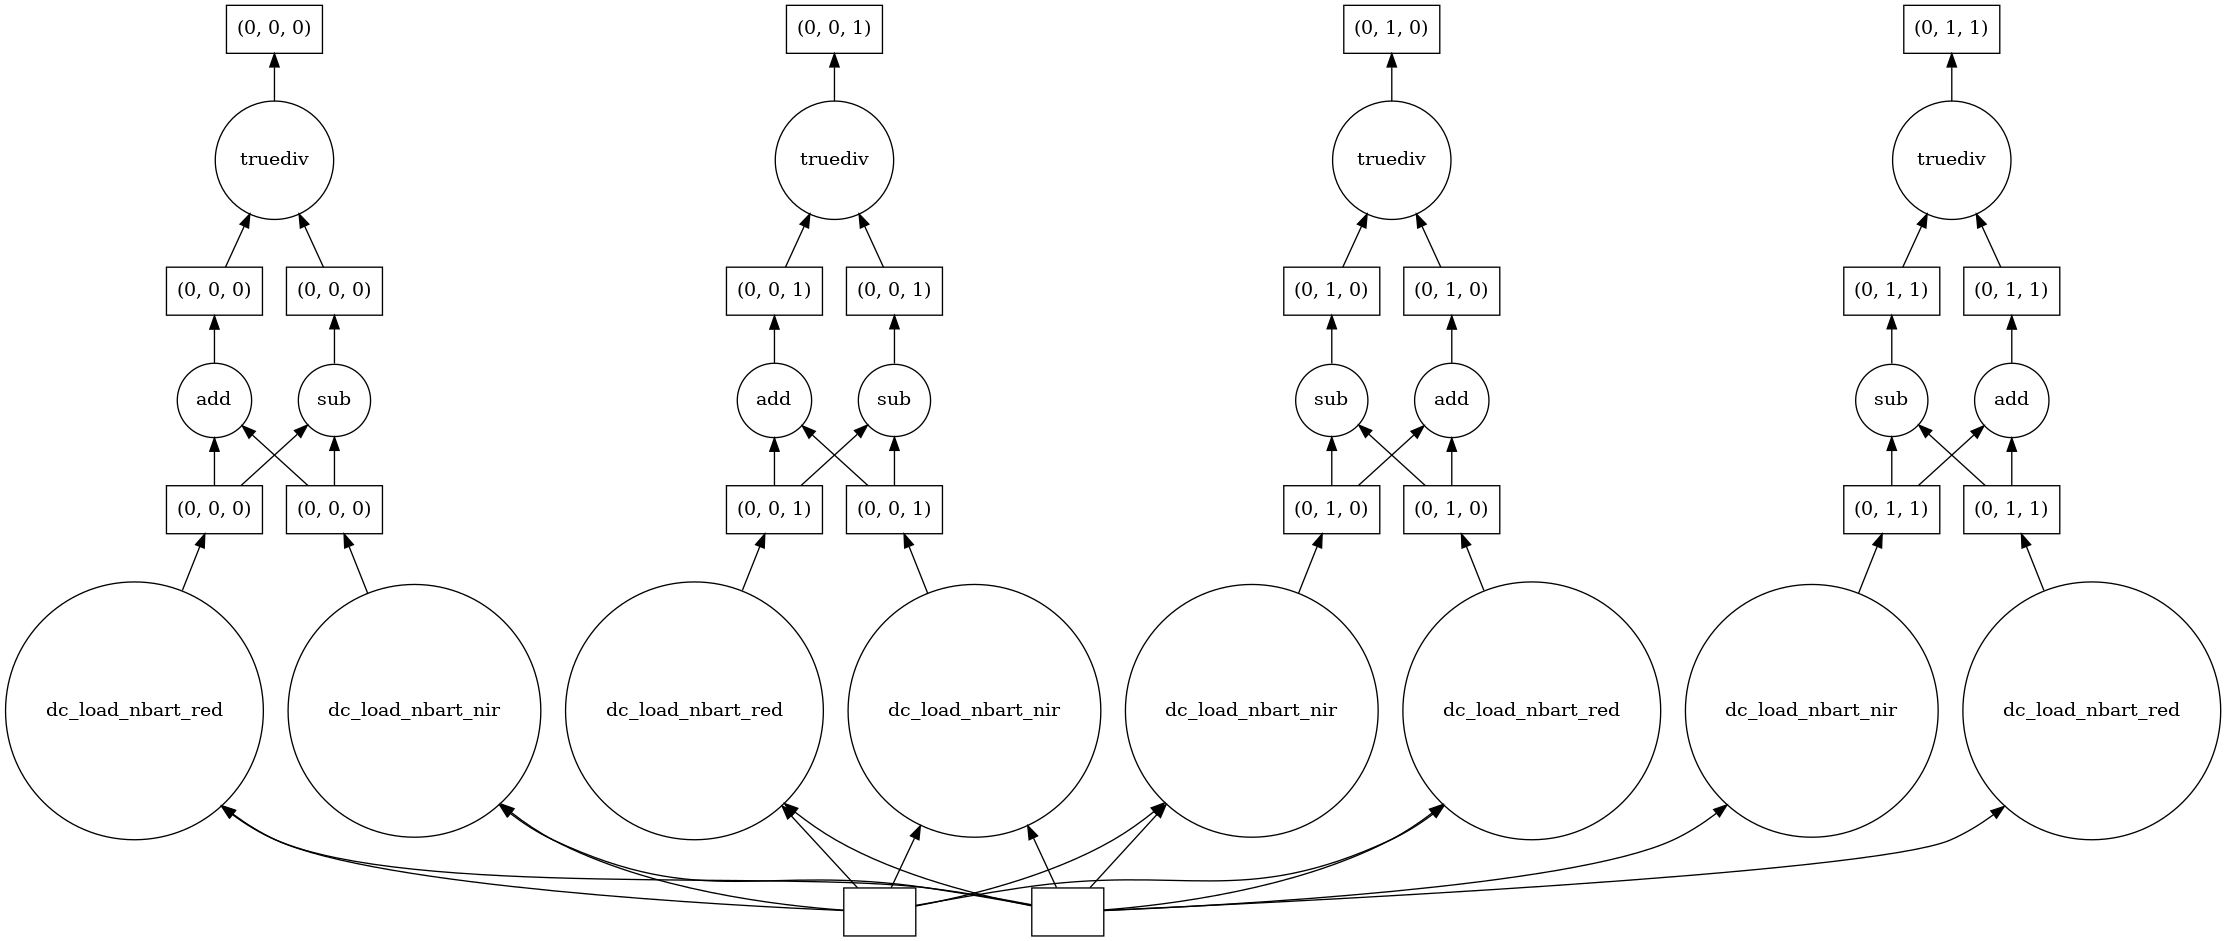

In [12]:
ndvi.data.visualize()

Reading the graph bottom-to-top, we can see the equation taking place. The `add` and `sub` are performed on each band before being divided.

We can see how each output chunk in independant from the others.  This means we could calculate each chunk independently, without ever having to load all of the bands into memory at the same time.

We can also run the steps to produce each chunk at the same time.  By default, `dask` will use multiple threads on your local machine. A better way to use dask is with a `distributed` cluster.

## Dsitributed Dashboard

When using `dask` in Jupyter Lab, activate the dask dashboard to get an overview of the processing that is being done by the processing cluster.

To display the dashboard, click the dask button on the side toolbar:

![Image](dask.png)

If there are no clusters in the list, click **+NEW**

Click the **< >** button to add the client code to your notebook:

In [14]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35651")
client

Client Scheduler: tcp://127.0.0.1:35651 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 17.18 GB


Click the **PROGRESS** button on the dask panel, and drag the new **Dask Progress** tab to the bottom of the screen so you can see your notebook and progress window at the same time.

Run the `.compute()` command, and watch the tree be processed:

In [19]:
ndvi.compute()

<xarray.DataArray (time: 1, y: 4062, x: 3473)>
array([[[ 0.22541744,  0.2337033 ,  0.24879615, ..., -0.        ,
         -0.        , -0.        ],
        [ 0.22477276,  0.23438717,  0.25422094, ..., -0.        ,
         -0.        , -0.        ],
        [ 0.2227821 ,  0.23100775,  0.26280193, ..., -0.        ,
         -0.        , -0.        ],
        ...,
        [ 0.3972928 ,  0.3897497 ,  0.35236313, ...,  0.51140858,
          0.43268916,  0.45397816],
        [ 0.34006248,  0.30994692,  0.28535755, ...,  0.50344828,
          0.45547726,  0.44044142],
        [ 0.30137915,  0.28267612,  0.28758605, ...,  0.47763975,
          0.45547726,  0.47291733]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01T23:56:37.516439
  * y        (y) float64 -4.035e+06 -4.035e+06 ... -3.913e+06 -3.913e+06
  * x        (x) float64 1.439e+06 1.439e+06 1.439e+06 ... 1.543e+06 1.543e+06

Unlike `.load()`, when you run `.compute()` it does not change the `ndvi` variable, so your can run it again:

In [ ]:
ndvi.compute()

![Image](dask_screenshot.png)

## Caveats

* Chunks must align